# Predicting Stock Prices In Python Code

Deep learning is getting a lot of attention these days, and for good reason. It’s achieving unprecedented levels of accuracy—to the point where deep learning algorithms can outperform humans at predicting figures, classifying images, and translating text. 

This program aims to understand how LSTM works with a case study of predicting **Amazon** stock prices. 

**What is LSTM**
- Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used. LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn! All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

In [18]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
import pickle
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

## Load data

In [57]:
company = 'AMZN' # Amazon stock symbol
past_days =  30 # number of days we used for predicting stock price for next day
start_date = dt.datetime(2011, 1, 1) # start date for data
end_date = dt.datetime(2021, 1, 1) # end date for data

data = web.DataReader(company, 'yahoo', start_date, end_date)

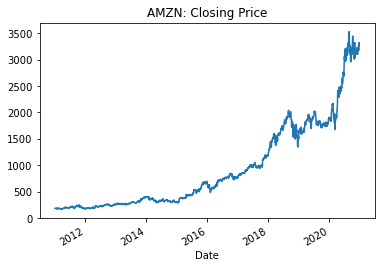

In [58]:
# show Amazon's closing stock price last 10 years
data['Close'].plot(title='{}: Closing Price'.format(company))

In [59]:
# show data as table
data[['Close']]

,Close
Date,
2010-12-31,180.000000
2011-01-03,184.220001
2011-01-04,185.009995
2011-01-05,187.419998
2011-01-06,185.860001
...,...
2020-12-24,3172.689941
2020-12-28,3283.959961
2020-12-29,3322.000000


## Prepare Data

### Scale Data

In [60]:
# use sklearn.MinMaxScaler to scale data
scaler = MinMaxScaler(feature_range=(0,1)) # scale stock price between 0 to 1
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1)) # reshape to 1 column regardless number of rows

### Extract training and label data

In [61]:
x_train = []
y_train = []
past_days = 50
for x in range(past_days, len(scaled_data)):
    x_train.append(scaled_data[x-past_days:x, 0]) # 50 days for training
    y_train.append(scaled_data[x, 0])             # actual stock price(scaled) for label

In [62]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 
x_train.shape

(2468, 50, 1)

## Build Model

In [63]:
"""
    we use sequential model that is appropriate 
     for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
"""
pred_model = Sequential() 
# units is dimensionality of the layers' output 
pred_model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
pred_model.add(Dropout(0.2)) # 20% of input will be randomly excluded for preventing overfit training data 
pred_model.add(LSTM(units = 50, return_sequences = True))
pred_model.add(Dropout(0.2))
pred_model.add(LSTM(units = 50))
pred_model.add(Dropout(0.2))
pred_model.add(Dense(units=1)) # the output shape set to 1
# set optimizer               
pred_model.compile(optimizer = 'adam', loss='mean_squared_error')
# fit data to the model
pred_model.fit(x_train, y_train, epochs=25, batch_size=32)                              

Epoch 1/25
78/78 [==============================] - 7s 40ms/step - loss: 0.0081
Epoch 2/25
78/78 [==============================] - 3s 42ms/step - loss: 0.0019
Epoch 3/25
78/78 [==============================] - 3s 39ms/step - loss: 0.0015
Epoch 4/25
78/78 [==============================] - 3s 39ms/step - loss: 0.0015
Epoch 5/25
78/78 [==============================] - 3s 40ms/step - loss: 0.0013
Epoch 6/25
78/78 [==============================] - 3s 36ms/step - loss: 0.0011
Epoch 7/25
78/78 [==============================] - 3s 36ms/step - loss: 0.0013
Epoch 8/25
78/78 [==============================] - 3s 36ms/step - loss: 0.0012
Epoch 9/25
78/78 [==============================] - 3s 37ms/step - loss: 0.0011
Epoch 10/25
78/78 [==============================] - 3s 36ms/step - loss: 0.0010
Epoch 11/25
78/78 [==============================] - 3s 36ms/step - loss: 0.0011
Epoch 12/25
78/78 [==============================] - 3s 36ms/step - loss: 0.0010
Epoch 13/25
78/78 [==================

### Save Model

In [64]:
# save model to disk

filename = 'trained_pred_model.pkl'
pred_model.save('model/')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [65]:
""" Load model
from tensorflow import keras
model = keras.models.load_model('model/')
"""

" Load model\nfrom tensorflow import keras\nmodel = keras.models.load_model('model/')\n"

## Test Model

### Create Test Data

In [66]:
test_start = dt.datetime(2021,1,1) # test data starts from the end of training date
test_end = dt.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values
# aggregate training data and test data, this will be used for testing model
total_data = pd.concat((data['Close'], test_data['Close']), axis=0)

### Model Inputs

In [67]:
model_inputs = total_data[len(total_data) - len(test_data) - past_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

### Make Predictions on Test data

In [68]:
x_test = []

for x in range(past_days, len(model_inputs)):
    x_test.append(model_inputs[x-past_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [69]:
predicted_prices = pred_model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

### Show predictions

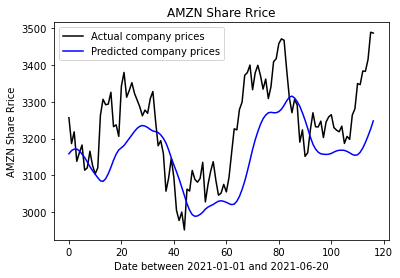

In [70]:
plt.plot(actual_prices, color='black', label='Actual company prices')
plt.plot(predicted_prices, color='blue', label='Predicted company prices')
plt.title("{} Share Rrice".format(company))
plt.xlabel('Date between {} and {}'.format(test_start.date(), test_end.date()))
plt.ylabel("{} Share Rrice".format(company))
plt.legend()
plt.show()

### Root Mean Square Error (RMSE)

In [72]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(actual_prices, predicted_prices))
rms

121.59988547370018

## Predict Next Day

In [71]:
real_data = [model_inputs[len(model_inputs) + 1 -past_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = pred_model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print("Prediction: {}".format(prediction))

Prediction: [[3271.72]]


# Summary

We develop this program to learn how to build a prediction model with the LSTM method. The built model can predict the next day stock price of Amazon base on the past 30 days. 